# Mask R-CNN - Inspect Ballon Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images, display_results
import mrcnn.model as modellib
from mrcnn.model import log

from custom.boxes import boxes

os.environ['CUDA_VISIBLE_DEVICES'] = ''
%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
BOXES_WEIGHTS_PATH = os.path.join(MODEL_DIR, "box20200908T1407/mask_rcnn_box_0010.h5")  # TODO: update this path

Using TensorFlow backend.


## Configurations

In [2]:
config = boxes.BoxConfig()
BOXES_DIR = "/home/mikkel/workspace/instance_segmentation/dataset/box_dataset"

In [4]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  640
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [640 640   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

## Notebook Preferences

In [5]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [6]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [7]:
# Load validation dataset
dataset = boxes.BoxDataset()
dataset.load_box(BOXES_DIR, "test2")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Images: 115
Classes: ['BG', 'box']


In [8]:
# Load validation dataset
dataset_test = boxes.BoxDataset()
dataset_test.load_box(BOXES_DIR, "test")

# Must call before using the dataset
dataset_test.prepare()

print("Images: {}\nClasses: {}".format(len(dataset_test.image_ids), dataset_test.class_names))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Images: 123
Classes: ['BG', 'box']


## Load Model

In [9]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

In [25]:
# Set path to balloon weights file

# Download file from the Releases page and set its path
# https://github.com/matterport/Mask_RCNN/releases
# weights_path = "/path/to/mask_rcnn_balloon.h5"

# Or, load the last model you trained

#weights_path = os.path.join(MODEL_DIR, "box20200928T1520/mask_rcnn_box_0140.h5")
weights_path = os.path.join(MODEL_DIR, "box20200925T1502_train1000_synth+new-real_heads40_res4+120_all160_real180/mask_rcnn_box_0180.h5")
#weights_path = model.find_last()
#weights_path = os.path.join(MODEL_DIR, "box20201002T1519box20200925T1502_train_15Ksynth+real_heads100_res4+200_real220/mask_rcnn_box_0200.h5")
#weights_path = os.path.join(MODEL_DIR, "box20200918T1508_train5000_finetuned_on_real_data/mask_rcnn_box_0020.h5")

#weights_path = os.path.join(MODEL_DIR, "box20200917T0748_train1000_synth_box_with_content_imagenet_heads-res4-all/mask_rcnn_box_0100.h5")


# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /home/mikkel/workspace/instance_segmentation/Mask_RCNN/logs/box20200925T1502_train1000_synth+new-real_heads40_res4+120_all160_real180/mask_rcnn_box_0180.h5


## Run Detection

In [11]:
import cv2
import time
import numpy as np
import PIL.Image
from io import BytesIO
import IPython.display
import ipywidgets as widgets
import threading
import time
import datetime
import pyrealsense2 as rs


class FPSCounter:
    def __init__(self):
        self._start = None
        self._end = None
        self._noFrames = 0

    def start(self):
        self._start = datetime.datetime.now()
        return self

    def stop(self):
        self._end = datetime.datetime.now()

    def update(self):
        self._noFrames += 1
    
    def elapsed(self):
        return (self._end - self._start).total_seconds()

    def fps(self):
        return self._noFrames/self.elapsed()

def get_realsense_images():
    while True:
        # Wait for a coherent pair of frames: depth and color
        frames = pipeline.wait_for_frames()
        depth_frame = frames.get_depth_frame()
        color_frame = frames.get_color_frame()
        #if not depth_frame or not color_frame:
        if not color_frame:
            continue
        # Convert images to numpy arrays
        depth_image = np.asanyarray(depth_frame.get_data())
        points = pc.calculate(depth_frame)
        # Grab new intrinsics (may be changed by decimation)
        depth_intrinsics = rs.video_stream_profile(depth_frame.profile).get_intrinsics()
        w, h = depth_intrinsics.width, depth_intrinsics.height
        xyz = np.asarray(points.get_vertices(2)).reshape(h, w, 3)
        color_image = np.asanyarray(color_frame.get_data())
        np.save("xyz.npy", xyz)
        np.save("rgb.npy", color_image)
        #return color_image, depth_image
        return color_image

#Use 'jpeg' instead of 'png' (~5 times faster)
def showarray(a, prev_display_id=None, fmt='jpeg'):
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    obj = IPython.display.Image(data=f.getvalue())
    if prev_display_id is not None:
        IPython.display.update_display(obj, display_id=prev_display_id)
        return prev_display_id
    else:
        return IPython.display.display(obj, display_id=True)

In [12]:
def get_detection(image):
    # Run object detection
    results = model.detect([image], verbose=0)

    # Display results
    r = results[0]
    boxes = r['rois']
    masks = r['masks']
    class_ids = r['class_ids']
    class_names = dataset.class_names
    scores = r['scores']
    n_instances = boxes.shape[0]
    colors = visualize.color_map()
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
        return None
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]
    # Generate random colors
    colors = visualize.random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        # Label
        class_id = class_ids[i]
        score = scores[i] if scores is not None else None
        label = class_names[class_id]
        caption = "{} {:.3f}".format(label, score) if score else label

        # Mask
        mask = masks[:, :, i]
        masked_image = visualize.apply_mask(masked_image, mask, color)
    return masked_image.astype(np.uint8)

In [28]:
# Declare pointcloud object, for calculating pointclouds and texture mappings
pc = rs.pointcloud()

# Configure depth and color streams
pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)
# Start streaming
pipeline.start(config)

<ipython-input-28-c5ac260287ce>:7: DeprecationWarning: an integer is required (got type pyrealsense2.pyrealsense2.format).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
<ipython-input-28-c5ac260287ce>:8: DeprecationWarning: an integer is required (got type pyrealsense2.pyrealsense2.format).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)


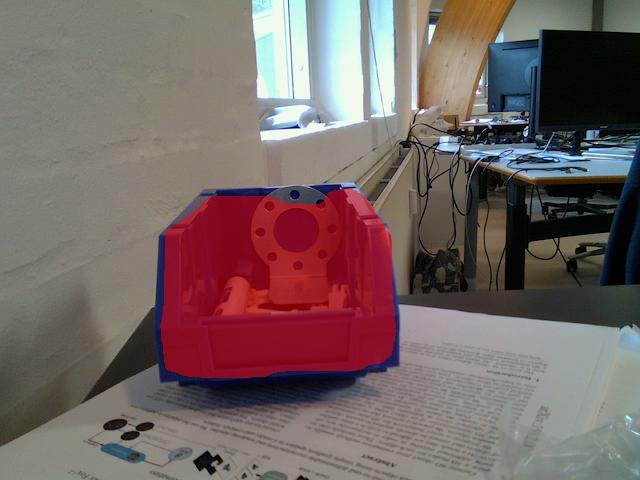

(480, 640)
FPS:  4.686561772301443
Elapsed seconds:  10.24205
Stream stopped


In [30]:
try:
    fps = FPSCounter().start()
    while True:
        # Capture frame-by-frame
        frame = cv2.cvtColor(get_realsense_images(), cv2.COLOR_BGR2RGB)
# Convert the image from OpenCV BGR format to matplotlib RGB format
        # to display the image
        detection = get_detection(frame)
        IPython.display.clear_output(wait=True)
        if detection is not None:
            showarray(detection)
        else:
            showarray(frame)
        # Display the frame info until new frame is available
        fps.update()
    print("Stream stopped")
except KeyboardInterrupt:
    fps.stop()
    print('FPS: ', fps.fps())
    print('Elapsed seconds: ', fps.elapsed())
    print("Stream stopped")

In [ ]:
pipeline.stop()

In [ ]:
# Configure depth and color streams
pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)
# Start streaming
pipeline.start(config)
try:
    for i in range(50):
        # Capture frame-by-frame
        frame = get_realsense_images()
# Convert the image from OpenCV BGR format to matplotlib RGB format
        # to display the image
        frame = get_detection(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        showarray(frame)
        # Display the frame info until new frame is available
        IPython.display.clear_output(wait=True)
except KeyboardInterrupt:
    pipeline.stop()
    print("Stream stopped")

In [ ]:
print(verts.shape)

In [11]:
import skimage
# Load a random image from the images folder
IMAGE_DIR = os.path.join(BOXES_DIR, "test/datasets/box_dataset")

file_names = list()
for (dirpath, dirnames, filenames) in os.walk(IMAGE_DIR):
    file_names += [os.path.join(dirpath, file) for file in filenames]


#file_names = next(os.walk(IMAGE_DIR))[2]
for count, file_name in enumerate(file_names):
    if count < 200: continue
    image = skimage.io.imread(os.path.join(IMAGE_DIR, file_name))
    #image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
    # Run object detection
    results = model.detect([image], verbose=1)
    # Display results
    ax = get_ax(1)
    r = results[0]
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], ax=ax,
                                title="Predictions")
    name = "detections/" + str(count).zfill(4) + ".jpg"
    plt.savefig(name ,bbox_inches='tight', pad_inches=-0.5,orientation= 'landscape')
    plt.clf()
    #if count == 200: break

Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  640.00000  float64
anchors                  shape: (1, 102300, 4)        min:   -0.28329  max:    1.18313  float32
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  640.00000  float64
anchors                  shape: (1, 102300, 4)        min:   -0.28329  max:    1.18313  float32
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.1

<ipython-input-5-30cc81e34ca0>:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))


Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  640.00000  float64
anchors                  shape: (1, 102300, 4)        min:   -0.28329  max:    1.18313  float32
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  640.00000  float64
anchors                  shape: (1, 102300, 4)        min:   -0.28329  max:    1.18313  float32
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.1

Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  640.00000  float64
anchors                  shape: (1, 102300, 4)        min:   -0.28329  max:    1.18313  float32
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  640.00000  float64
anchors                  shape: (1, 102300, 4)        min:   -0.28329  max:    1.18313  float32
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.1

Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  640.00000  float64
anchors                  shape: (1, 102300, 4)        min:   -0.28329  max:    1.18313  float32
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  640.00000  float64
anchors                  shape: (1, 102300, 4)        min:   -0.28329  max:    1.18313  float32
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.1

Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  145.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  640.00000  float64
anchors                  shape: (1, 102300, 4)        min:   -0.28329  max:    1.18313  float32
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  640.00000  float64
anchors                  shape: (1, 102300, 4)        min:   -0.28329  max:    1.18313  float32
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  150.1

Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  640.00000  float64
anchors                  shape: (1, 102300, 4)        min:   -0.28329  max:    1.18313  float32
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  640.00000  float64
anchors                  shape: (1, 102300, 4)        min:   -0.28329  max:    1.18313  float32
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.1

Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  640.00000  float64
anchors                  shape: (1, 102300, 4)        min:   -0.28329  max:    1.18313  float32
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  640.00000  float64
anchors                  shape: (1, 102300, 4)        min:   -0.28329  max:    1.18313  float32
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.1

Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  145.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  640.00000  float64
anchors                  shape: (1, 102300, 4)        min:   -0.28329  max:    1.18313  float32
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  640.00000  float64
anchors                  shape: (1, 102300, 4)        min:   -0.28329  max:    1.18313  float32
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  150.1

Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  640.00000  float64
anchors                  shape: (1, 102300, 4)        min:   -0.28329  max:    1.18313  float32
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  640.00000  float64
anchors                  shape: (1, 102300, 4)        min:   -0.28329  max:    1.18313  float32
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.1

Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  640.00000  float64
anchors                  shape: (1, 102300, 4)        min:   -0.28329  max:    1.18313  float32
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  640.00000  float64
anchors                  shape: (1, 102300, 4)        min:   -0.28329  max:    1.18313  float32
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.1

Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  640.00000  float64
anchors                  shape: (1, 102300, 4)        min:   -0.28329  max:    1.18313  float32
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  640.00000  float64
anchors                  shape: (1, 102300, 4)        min:   -0.28329  max:    1.18313  float32
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.1

ValueError: Could not find a format to read the specified file in single-image mode

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

<Figure size 1152x1152 with 0 Axes>

In [ ]:
#ax = get_ax(1)
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
#print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
#                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=0)

# Display results
r = results[0]
boxes = r['rois']
masks = r['masks']
class_ids = r['class_ids']
class_names = dataset.class_names
scores = r['scores']
n_instances = boxes.shape[0]
colors = visualize.color_map()
#print(colors)
#colors = visualize.random_colors(n_instances)
#print(colors)
for k in range(n_instances):
    color = colors[class_ids[k]].astype(np.uint8)
    box = boxes[k]
    cls = class_names[class_ids[k]-1]  # Skip the Background
    score = scores[k]
    #print((box[1], box[0]), (box[3], box[2]), color, 1)
    #cv2.rectangle(image, (box[1], box[0]), (box[3], box[2]), color, 1)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(image, '{}: {:.3f}'.format(cls, score), (box[1], box[0]),
                font, 0.4, (0, 255, 255), 1, cv2.LINE_AA)

    mask = masks[:, :, k]
    color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.int)
    color_mask[mask] = color
    image = cv2.addWeighted(color_mask, 0.5, image.astype(np.int), 1, 0)

plt.imshow(image)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()
cv2.imwrite("test.jpg", image)

In [ ]:
#ax = get_ax(1)
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=0)

# Display results
r = results[0]
boxes = r['rois']
masks = r['masks']
class_ids = r['class_ids']
class_names = dataset.class_names
scores = r['scores']
n_instances = boxes.shape[0]
colors = visualize.color_map()
# Number of instances
N = boxes.shape[0]
print(r['rois'])
if not N:
    print("\n*** No instances to display *** \n")
else:
    assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

# If no axis is passed, create one and automatically call show()
#auto_show = False
#if not ax:
#    _, ax = plt.subplots(1, figsize=figsize)
#    auto_show = True

# Generate random colors
colors = visualize.random_colors(N)

# Show area outside image boundaries.
height, width = image.shape[:2]
#ax.set_ylim(height + 10, -10)
#ax.set_xlim(-10, width + 10)
#ax.axis('off')
#ax.set_title(title)

masked_image = image.astype(np.uint32).copy()
for i in range(N):
    color = colors[i]

    # Bounding box
    if not np.any(boxes[i]):
        # Skip this instance. Has no bbox. Likely lost in image cropping.
        continue
    y1, x1, y2, x2 = boxes[i]
    
    p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                        alpha=0.7, linestyle="dashed",
                        edgecolor=color, facecolor='none')
    #ax.add_patch(p)

    # Label
    class_id = class_ids[i]
    score = scores[i] if scores is not None else None
    label = class_names[class_id]
    caption = "{} {:.3f}".format(label, score) if score else label

    # Mask
    mask = masks[:, :, i]
    masked_image = visualize.apply_mask(masked_image, mask, color)

    # Mask Polygon
    # Pad to ensure proper polygons for masks that touch image edges.
    padded_mask = np.zeros(
        (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
    padded_mask[1:-1, 1:-1] = mask
    contours = visualize.find_contours(padded_mask, 0.5)
    for verts in contours:
        # Subtract the padding and flip (y, x) to (x, y)
        verts = np.fliplr(verts) - 1
        p = matplotlib.patches.Polygon(verts, facecolor="none", edgecolor=color)
        #ax.add_patch(p)
#ax.imshow(masked_image.astype(np.uint8))
showarray(masked_image.astype(np.uint8))


In [ ]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

## Evaluation

In [ ]:
image_ids = dataset_test.image_ids
APmeans = []
APs = []
print("TEST")
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_test, config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    if(r['masks'].shape[2] == 0):
        AP = 0
    else:
        AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask, 
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
print("mAP: ", np.mean(APs))

In [ ]:
image_ids = dataset.image_ids
APmeans = []

print("VAL")
for i in range(1, 101):
    model.load_weights(os.path.join(MODEL_DIR, 'box20200917T0748_train1000_synth_box_with_content_imagenet_heads-res4-all/mask_rcnn_box_' + str(i).zfill(4) + '.h5'), by_name=True)
    APs = []
    for image_id in image_ids[:100]:
        # Load image and ground truth data
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        molded_images = np.expand_dims(modellib.mold_image(image, config), 0)
        # Run object detection
        results = model.detect([image], verbose=0)
        r = results[0]
        # Compute AP
        if(r['masks'].shape[2] == 0):
            AP = 0
        else:
            AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        APs.append(AP)
    APmeans.append(np.mean(APs))
    print("Epoch ", i, " - mAP: ", np.mean(APs))
np.save('AP_train_imagenet_heads-res4-all', APmeans)

In [ ]:
image_ids = dataset.image_ids
APmeans = []

print("VAL")
for i in range(1, 41):
    model.load_weights(os.path.join(MODEL_DIR, 'box20200918T1508_train5000_finetuned_on_real_data/mask_rcnn_box_' + str(i).zfill(4) + '.h5'), by_name=True)
    APs = []
    for image_id in image_ids[:100]:
        # Load image and ground truth data
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        molded_images = np.expand_dims(modellib.mold_image(image, config), 0)
        # Run object detection
        results = model.detect([image], verbose=0)
        r = results[0]
        # Compute AP
        if(r['masks'].shape[2] == 0):
            AP = 0
        else:
            AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        APs.append(AP)
    APmeans.append(np.mean(APs))
    print("Epoch ", i, " - mAP: ", np.mean(APs))
np.save('AP_train_finetuned_on_real_data', APmeans)

In [ ]:
image_ids = dataset_test.image_ids
APmeans = []

print("TEST")
for i in range(1, 41):
    model.load_weights(os.path.join(MODEL_DIR, 'box20200918T1508_train5000_finetuned_on_real_data/mask_rcnn_box_' + str(i).zfill(4) + '.h5'), by_name=True)
    APs = []
    for image_id in image_ids:
        # Load image and ground truth data
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset_test, config,
                                   image_id, use_mini_mask=False)
        molded_images = np.expand_dims(modellib.mold_image(image, config), 0)
        # Run object detection
        results = model.detect([image], verbose=0)
        r = results[0]
        # Compute AP
        if(r['masks'].shape[2] == 0):
            AP = 0
        else:
            AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        APs.append(AP)
    APmeans.append(np.mean(APs))
    print("Epoch ", i, " - mAP: ", np.mean(APs))
np.save('AP_test_finetuned_on_real_data', APmeans)

In [ ]:
def movingaverage (values, window):
    return np.convolve(values, np.repeat(1.0, window)/window, 'valid')

epochs = range(1, 141)
#APtrain = np.load('APs/AP_train_hinterstoisser.npy')
#APval = np.load('APs/AP_val_hinterstoisser.npy')
#APtest = np.load('APs/AP_test_hinterstoisser.npy')
APtrain = np.concatenate([np.load('AP_train_imagenet_heads-res4-all.npy'), np.load('AP_train_finetuned_on_real_data.npy')])
APval = np.concatenate([np.load('AP_val_imagenet_heads-res4-all.npy'), np.load('AP_val_finetuned_on_real_data.npy')])
APtest = np.concatenate([np.load('AP_test_imagenet_heads-res4-all.npy'), np.load('AP_test_finetuned_on_real_data.npy')])

APtrainMA = movingaverage(APtrain, 3)
APtestMA = movingaverage(APtest, 3)
APvalMA = movingaverage(APval, 3)
#APtrainMA = movingaverage(APtrain, 3)
#APtestMA2 = movingaverage(APtest2, 3)
#APvalMA2 = movingaverage(APval2, 3)
#APtrainMA2 = movingaverage(APtrain2, 3)

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(epochs[len(epochs)-len(APtrainMA):], APtrainMA, 'b-')
plt.plot(epochs[len(epochs)-len(APvalMA):], APvalMA, 'r-')
plt.plot(epochs[len(epochs)-len(APtestMA):], APtestMA, 'g-')

#plt.plot(epochs[len(epochs)-len(APtrainMA2):], APtrainMA2, 'b--')
#plt.plot(epochs[len(epochs)-len(APvalMA2):], APvalMA2, 'r--')
#plt.plot(epochs[len(epochs)-len(APtestMA2):], APtestMA2, 'g--')
#plt.plot(epochs, APtrain, 'bo', markersize=2)
#plt.plot(epochs, APval, 'ro', markersize=2)
#plt.plot(epochs, APtest, 'go', markersize=2)
#plt.plot(epochs, APtestcup, 'co', markersize=2)
#plt.plot(epochs, APtestcup, 'mo', markersize=2)
plt.legend(('train','val','test'), loc='right', bbox_to_anchor=(1, 0.65))
plt.savefig("graph.svg")
plt.show()

## Step by Step Prediction

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [ ]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )


In [ ]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

### 1.b RPN Predictions

Here we run the RPN graph and display its predictions.

In [ ]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

In [ ]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

In [ ]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 50
ax = get_ax(1, 2)
pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], image.shape[:2])
refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], image.shape[:2])
refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image.shape[:2])
visualize.draw_boxes(image, boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[:limit], ax=ax[1])

In [ ]:
# Show refined anchors after non-max suppression
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[ixs], ax=get_ax())

In [ ]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [ ]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

In [ ]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [ ]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

In [ ]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

#### Apply Bounding Box Refinement

In [ ]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

#### Filter Low Confidence Detections

In [ ]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

In [ ]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

#### Per-Class Non-Max Suppression

In [ ]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

In [ ]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.a Mask Targets

These are the training targets for the mask branch

In [ ]:
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [ ]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

In [ ]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

In [ ]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

In [ ]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [ ]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

In [ ]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

In [ ]:
# Backbone feature map
display_images(np.transpose(activations["res2c_out"][0,:,:,:4], [2, 0, 1]), cols=4)